In [46]:
import pandas as pd
from database.connect import getConnection
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
sns.set()


from pathlib import Path
from processes.reply4_3 import reply_set_up, split_df, welch_test
import statistics
from sklearn import linear_model
import database.connect


# **CLEAR OUTPUTS BEFORE PUSHING TO GIT**
Press the clear all outputs button in the toolbar above before pushing to git.  
This makes version control easier and avoids merge conflicts. 

In [47]:
start_date = '01-01-2000'
end_date = '01-01-2023'

# convert start and end date to unix timestamp in milliseconds
start_date_unix = int(datetime.strptime(start_date, '%d-%m-%Y').timestamp() * 1000)
end_date_unix = int(datetime.strptime(end_date, '%d-%m-%Y').timestamp() * 1000)

# create a part you can insert into your where clause
date_restriction = f" AND tweets.timestamp_ms >= {start_date_unix} AND tweets.timestamp_ms <= {end_date_unix}"

The cell below creates the connection to the database and the cursor to execute queries.  
It also contains variables relevant everywhere in the notebook.

In [48]:
try:
    connection = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

cursor = connection.cursor()

categories = {'booking': ['booking', 'booked', 'book', 'ticket', 'tickets'],
            'canceling': ['canceled', 'cancellations'],
            'money': ['refund', 'compensation', 'claim', 'money', 'pay', 'paid'],
            'baggage': ['bag', 'baggage', 'luggage', 'bags'],
            'staff': ['staff', 'crew'],
            'waiting': ['waiting', 'delay', 'wait'],
            'boarding': ['boarding'],
            'stuck': ['stuck'],

            'information': ['info', 'information'],
            'customers': ['customer', 'customers', 'passenger', 'passengers'],
            'dm': [' dm'], 
            }

airlines_dict = {'KLM': ['klm'],
                'AirFrance':['airfrance',
                            'air france'],
                'British_Airways': ['british_airways',
                                    'british airways'],
                'AmericanAir': ['americanair',
                                'american airlines'],
                'Lufthansa': ['lufthansa'],
                'AirBerlin': ['airberlin',
                                'air berlin'],
                'AirBerlin assist': ['airberlin assist',
                                    'air berlin assist',
                                    'airberlinassist'],
                'easyJet': ['easyjet'],
                'RyanAir': ['ryanair'],
                'SingaporeAir': ['singaporeair',
                                'singapore airlines'],
                'Qantas': ['qantas'],
                'EtihadAirways': ['etihad airways',
                                'etihadairways',
                                'etihad'],
                'VirginAtlantic': ['virgin atlantic',
                                    'virginatlantic'],
            }

airlines_of_interest = ['AmericanAir', 'Other', 'British_Airways']

## Category visualisation

In [49]:
# create a dataframe with the counts of each category
excluided = ['dm', 'customers', 'information']
relevant_categories = [key for key in categories.keys() if key not in excluided]
columns = ['total'] + relevant_categories

base_path = Path('./pre-processed/')

# create a dataframe with the counts of each category, restricted by timestamp_ms
df = pd.DataFrame(columns=columns)
for airline in airlines_of_interest:
    df_airline = pd.read_csv(base_path / f'{airline}_category_counts.csv')
    length = len(df_airline.index)
    df_airline = df_airline[df_airline['timestamp_ms'] >= start_date_unix]
    df_airline = df_airline[df_airline['timestamp_ms'] <= end_date_unix]
    df_airline = df_airline.sum().to_frame().T
    df_airline['total'] = length
    df_airline['airline'] = airline
    df = pd.concat([df, df_airline])


df_category_counts = df.set_index('airline')

## Category table

In [50]:
# turn the dataframe into a table that shows both the counts, aswell as the keywords
df_category_counts_table = df_category_counts.copy()
df_category_counts_table = df_category_counts_table.drop(columns=['total'])
df_category_counts_table = df_category_counts_table.transpose()
df_category_counts_table = df_category_counts_table.reset_index()
df_category_counts_table = df_category_counts_table.rename(columns={'index': 'category'})
df_category_counts_table = df_category_counts_table.set_index('category')

# add a column that displays the keywords for each category
for category in relevant_categories:
    keywords = categories[category]
    df_category_counts_table.loc[category, 'keywords'] = ", ".join(keywords)

df_category_counts_table

airline,AmericanAir,Other,British_Airways,keywords
category,,,,
booking,29180,156547,53911,"booking, booked, book, ticket, tickets"
canceling,4775,11383,2303,"canceled, cancellations"
money,25367,164869,34256,"refund, compensation, claim, money, pay, paid"
baggage,26042,94871,22776,"bag, baggage, luggage, bags"
staff,14662,65115,17726,"staff, crew"
waiting,46004,119934,34814,"waiting, delay, wait"
boarding,5559,18579,3376,boarding
stuck,3374,13510,2150,stuck
timestamp_ms,538195075857027008.0,2641845021756311040.0,484864832417714112.0,NaN


## Category chart

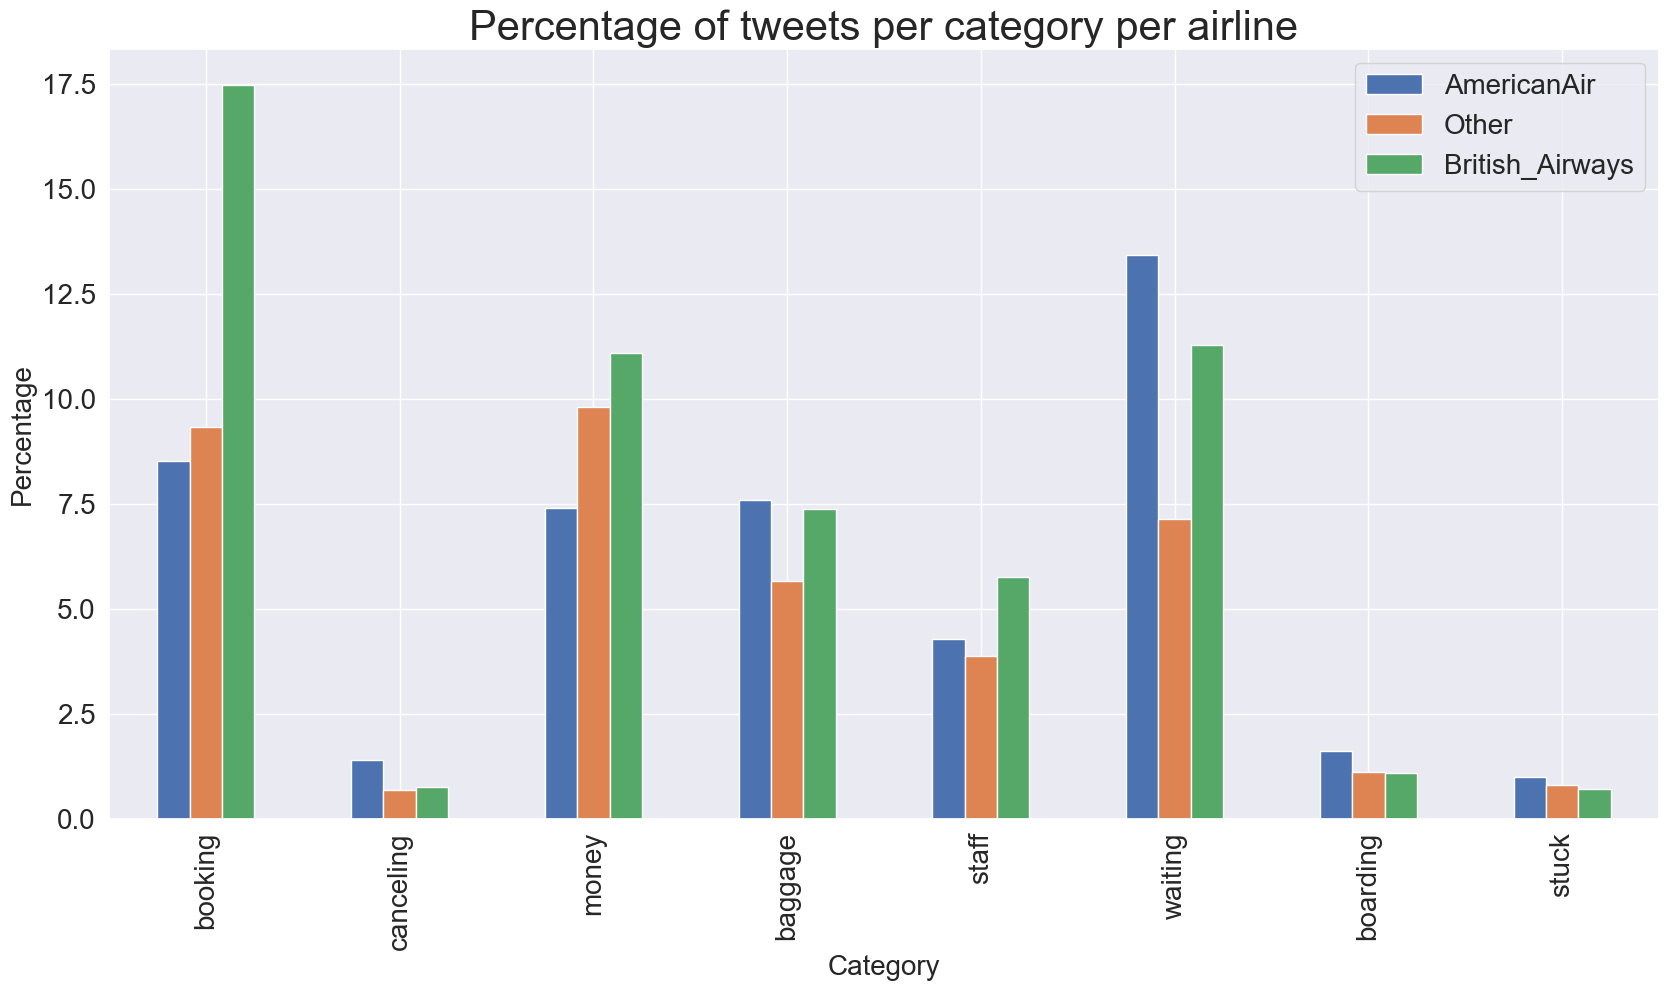

In [51]:
# create a dataframe for the percentages
df_category_percentages = pd.DataFrame(columns=relevant_categories)

# create rows for each airline and initialize with NaN values
for airline in airlines_of_interest:
    df_category_percentages.loc[airline] = np.nan


# calculate the percentage of each category, restricted to 2 decimal points
for category in relevant_categories:
    if category == 'total':
        continue
    for airline in airlines_of_interest:
        raw_percentage = df_category_counts.loc[airline][category] / df_category_counts.loc[airline]['total'] * 100
        percentage = round(raw_percentage, 2)
        df_category_percentages.loc[airline, category] = percentage

# Convert relevant columns to numeric type
df_category_percentages[relevant_categories] = df_category_percentages[relevant_categories].apply(pd.to_numeric)


# create a grouped bar chart 
# df_category_percentages.plot.bar(figsize=(20, 10), fontsize=20)
# plt.title('Percentage of tweets per category', fontsize=30)
# plt.xlabel('Airline', fontsize=20)
# plt.ylabel('Percentage', fontsize=20)
# plt.legend(fontsize=20)
# plt.show()

# create a grouped bar chart grouped by category
df_category_percentages.transpose().plot.bar(figsize=(20, 10), fontsize=20)
plt.title('Percentage of tweets per category per airline', fontsize=30)
plt.xlabel('Category', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Sentiment evolution in conversations (Oscar)

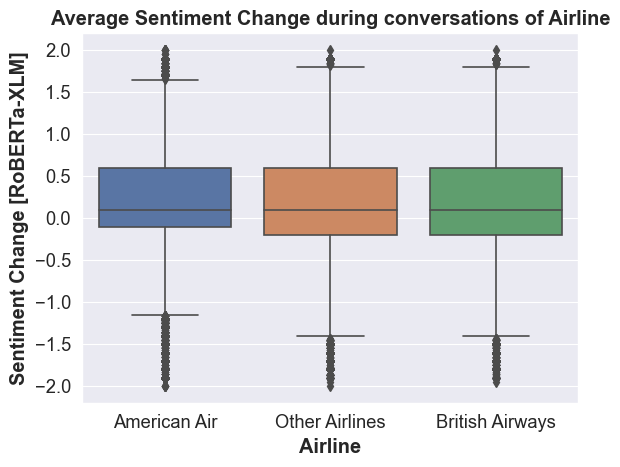

In [52]:
cursor.execute(f""" SELECT bs.bin_id, bs.cID, bs.bin_position, bs.break_airline, bs.sentiment_sum, bs.tweet_count, c.Tstart, c.Tend
                    FROM binned_sentiment bs, conversations c
                    WHERE bs.cID = c.id AND bs.break_airline NOT LIKE 'prev=%'""")
binned_sentiment = cursor.fetchall()
#all bins from conversations with more than 1 bin.

query = f""" SELECT CASE WHEN bs1.break_airline='AmericanAir' THEN "American Air" 
                        WHEN bs1.break_airline = 'British_Airways' THEN "British Airways" 
                        ELSE "Other Airlines" END AS Airline, 
            CASE WHEN (bs1.sentiment_sum / bs1.tweet_count) > (bs2.sentiment_sum / bs2.tweet_count) THEN -1*ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
            ELSE ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
            END AS Average_sent_diff
            FROM `binned_sentiment` bs1, `binned_sentiment` bs2
            WHERE bs1.cID = bs2.cID AND bs2.bin_position = bs1.bin_position + 1 
            AND bs1.cID IN (SELECT id
                            FROM conversations
                            WHERE Tstart > {start_date_unix} AND Tend < {end_date_unix})"""
cursor.execute(query) #the airlines and average sentiment change per 
sentiment_change = cursor.fetchall()

df_sentiment_change = pd.DataFrame(sentiment_change)
df_sentiment_change.rename(columns ={0:"Airline",1:"Sentiment Change [RoBERTa-XLM]"}, inplace=True)
df_sentiment_change["Sentiment Change [RoBERTa-XLM]"] = df_sentiment_change["Sentiment Change [RoBERTa-XLM]"].astype(float)
#initialize a dataframe with the query data.

sns.set_context("paper", font_scale = 1.5)
ax = sns.boxplot(data=df_sentiment_change,x='Airline',y='Sentiment Change [RoBERTa-XLM]', order= ['American Air','Other Airlines',
                                                                                                  'British Airways'])
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight':'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight':'bold'})
ax.set_title('Average Sentiment Change during conversations of Airline',weight='bold'); #graph the data from the dataframe into 3 boxplots

In [53]:
cursor.close()
connection.close()

### Sentiment Change over reply-time per topic
All functions found in processes.reply4_3.py

In [54]:
"""
Create dataframe from SQL query
NOTE: make sure to have the right data-base.
--> Expected running time: 20 sec
"""
df_tweets = reply_set_up()
print(len(df_tweets.index))
#df_tweets.head()

84768


In [55]:
# Only select the desired dates
df_tweets = df_tweets[df_tweets['timestamp_ms'] >= start_date_unix]
df_tweets = df_tweets[df_tweets['timestamp_ms'] <= end_date_unix]
print(len(df_tweets.index))

84768


In [56]:
"""Convert sentiment score to pos, neu, neg"""

# Bin column sentiment1 (first bin) -> (pos=1, neu=0, neg=-1)
df_tweets.loc[df_tweets['sentiment1'] < -0.2, 'sentiment1'] = -1
df_tweets.loc[df_tweets['sentiment1'] > -0.2, 'sentiment1'] = 1
df_tweets.loc[(df_tweets['sentiment1']  >= -0.2) & (df_tweets['sentiment1'] <= 0.2), 'sentiment1'] = 0

# Bin column sentiment2 (second bin) -> (pos=1, neu=0, neg=-1)
df_tweets.loc[df_tweets['sentiment2'] < -0.2, 'sentiment2'] = -1
df_tweets.loc[df_tweets['sentiment2'] > -0.2, 'sentiment2'] = 1
df_tweets.loc[(df_tweets['sentiment2']  >= -0.2) & (df_tweets['sentiment2'] <= 0.2), 'sentiment2'] = 0

#df_tweets.head()

In [57]:
# Calculate the difference between sentiment 1 and 2

df_tweets['sentiment_change'] = df_tweets['sentiment2'] - df_tweets['sentiment1']
#df_tweets.head()

In [58]:
""""
Clearing the data frames.
"""

# Creating a data frame per topic
df_canceling = df_tweets[df_tweets['canceling'] != 0][['reply_time', 'sentiment_change']]
df_boarding = df_tweets[df_tweets['boarding'] != 0][['reply_time', 'sentiment_change']]
df_stuck = df_tweets[df_tweets['stuck'] != 0][['reply_time', 'sentiment_change']]
df_booking = df_tweets[df_tweets['booking'] != 0][['reply_time', 'sentiment_change']]
df_customers = df_tweets[df_tweets['customers'] != 0][['reply_time', 'sentiment_change']]
df_dm = df_tweets[df_tweets['dm'] != 0][['reply_time', 'sentiment_change']]
df_waiting = df_tweets[df_tweets['waiting'] != 0][['reply_time', 'sentiment_change']]
df_money = df_tweets[df_tweets['money'] != 0][['reply_time', 'sentiment_change']]
df_information = df_tweets[df_tweets['information'] != 0][['reply_time', 'sentiment_change']]
df_staff = df_tweets[df_tweets['staff'] != 0][['reply_time', 'sentiment_change']]
df_baggage = df_tweets[df_tweets['baggage'] != 0][['reply_time', 'sentiment_change']]


# Binned of 1 min
df_canceling_gro = df_canceling[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_boarding_gro = df_boarding[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_stuck_gro = df_stuck[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_booking_gro = df_booking[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_customers_gro = df_customers[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_dm_gro = df_dm[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_waiting_gro = df_waiting[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_money_gro = df_money[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_information_gro = df_information[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_staff_gro = df_staff[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_baggage_gro = df_baggage[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()

In [59]:
# Checking the number ineach category

canceling_len = len(df_canceling.index)
boarding_len = len(df_boarding.index)
stuck_len = len(df_stuck.index)
booking_len = len(df_booking.index)
customers_len = len(df_customers.index)
dm_len = len(df_dm.index)
waiting_len = len(df_waiting.index)
money_len = len(df_money.index)
information_len = len(df_information.index)
staff_len = len(df_staff.index)
baggage_len = len(df_baggage.index)

print(f"""
      TOPIC COUNT
      canceling: {canceling_len}
      boarding: {boarding_len}
      stuck: {stuck_len}
      booking: {booking_len}
      customers: {customers_len}
      dm: {dm_len}
      waiting: {waiting_len}
      money: {money_len}
      information: {information_len}
      staff: {staff_len}
      baggage: {baggage_len}
      """)


      TOPIC COUNT
      canceling: 3381
      boarding: 5297
      stuck: 3049
      booking: 37229
      customers: 35884
      dm: 28516
      waiting: 32631
      money: 29934
      information: 27743
      staff: 17419
      baggage: 19157
      


In [60]:
# Get quantiles of the most relevant topics
baggage_qua5 = df_baggage['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
boarding_qua5 = df_boarding['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
booking_qua5 = df_booking['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
information_qua5 = df_information['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
money_qua5 = df_money['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
waiting_qua5 = df_waiting['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])

In [61]:
# Data frames, split by quantiles, for every topic
df_baggage_4 = split_df(df_baggage, baggage_qua5)
df_boarding_4 = split_df(df_boarding, boarding_qua5)
df_booking_4 = split_df(df_booking, booking_qua5)
df_information_4 = split_df(df_information, information_qua5)
df_money_4 = split_df(df_money, money_qua5)
df_waiting_4 = split_df(df_waiting, waiting_qua5)

In [62]:
# Calculate p-values for different quantiles and topics
# Return a dataframe with all p-values
p_baggage = welch_test(df_baggage_4, 'baggage')
p_boarding = welch_test(df_boarding_4, 'boarding')
p_booking = welch_test(df_booking_4, 'booking')
p_information = welch_test(df_information_4, 'information')
p_money = welch_test(df_money_4, 'money')
p_waiting = welch_test(df_waiting_4, 'waiting')

ds = [p_baggage, p_boarding, p_booking, p_information, p_money, p_waiting]

df_p = pd.DataFrame(ds)
df_p

,topic,25 vs. 50,50 vs. 75,75 vs. 100,low vs high
0,baggage,0.017857,0.669526,0.633710,0.278724
1,boarding,0.142195,0.078321,0.949495,0.067599
2,booking,0.081020,0.332567,0.075945,0.005564
3,information,0.047265,0.517012,0.246263,0.068662
4,money,0.079032,0.479833,0.055996,0.016875
5,waiting,0.017050,0.930008,0.174933,0.479054


Text(0, 0.5, 'Sentiment Change [XLM-RoBERTA]')

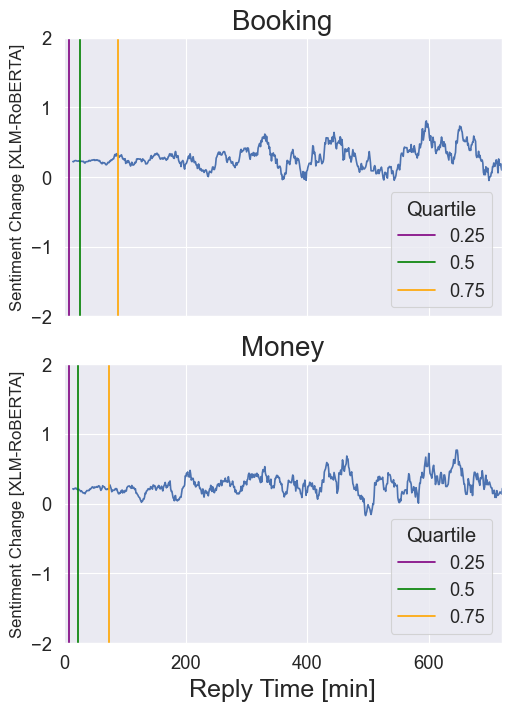

In [83]:
"""
Plot only the 3 most relevant ones.
"""
# Plot the results in line-plot with marked quantiles

fig, ax = plt.subplots(nrows=2, figsize=(5,7), sharey=True, sharex=True, layout="constrained")
plt.setp(ax, ylim=(-2,2))
plt.setp(ax, xlim=(-2,720))


# Booking
sns.lineplot(data=df_booking_gro, x='reply_time', y='sentiment_change', ax=ax[0])
ax[0].axvline(x = booking_qua5[0.25], c='purple', label='0.25')
ax[0].axvline(x = booking_qua5[0.5], c='green', label='0.5')
ax[0].axvline(x = booking_qua5[0.75], c='orange', label='0.75')
ax[0].legend(title = 'Quartile')
ax[0].set_title('Booking', size=20)
ax[0].set_ylabel('Sentiment Change [XLM-RoBERTA]', size=12)

# Money
sns.lineplot(data=df_money_gro, x='reply_time', y='sentiment_change', ax=ax[1])
ax[1].axvline(x = waiting_qua5[0.25], c='purple', label='0.25')
ax[1].axvline(x = waiting_qua5[0.5], c='green', label='0.5')
ax[1].axvline(x = waiting_qua5[0.75], c='orange', label='0.75')
ax[1].legend(title = 'Quartile')
ax[1].set_title('Money', size=20)
ax[1].set_xlabel('Reply Time [min]', size=18)
ax[1].set_ylabel('Sentiment Change [XLM-RoBERTA]', size=12)

#fig.suptitle('Sentiment Change over Airline \n Reply-Time in Conversations, Per Topic', weight='bold', size=20, y=1.10);

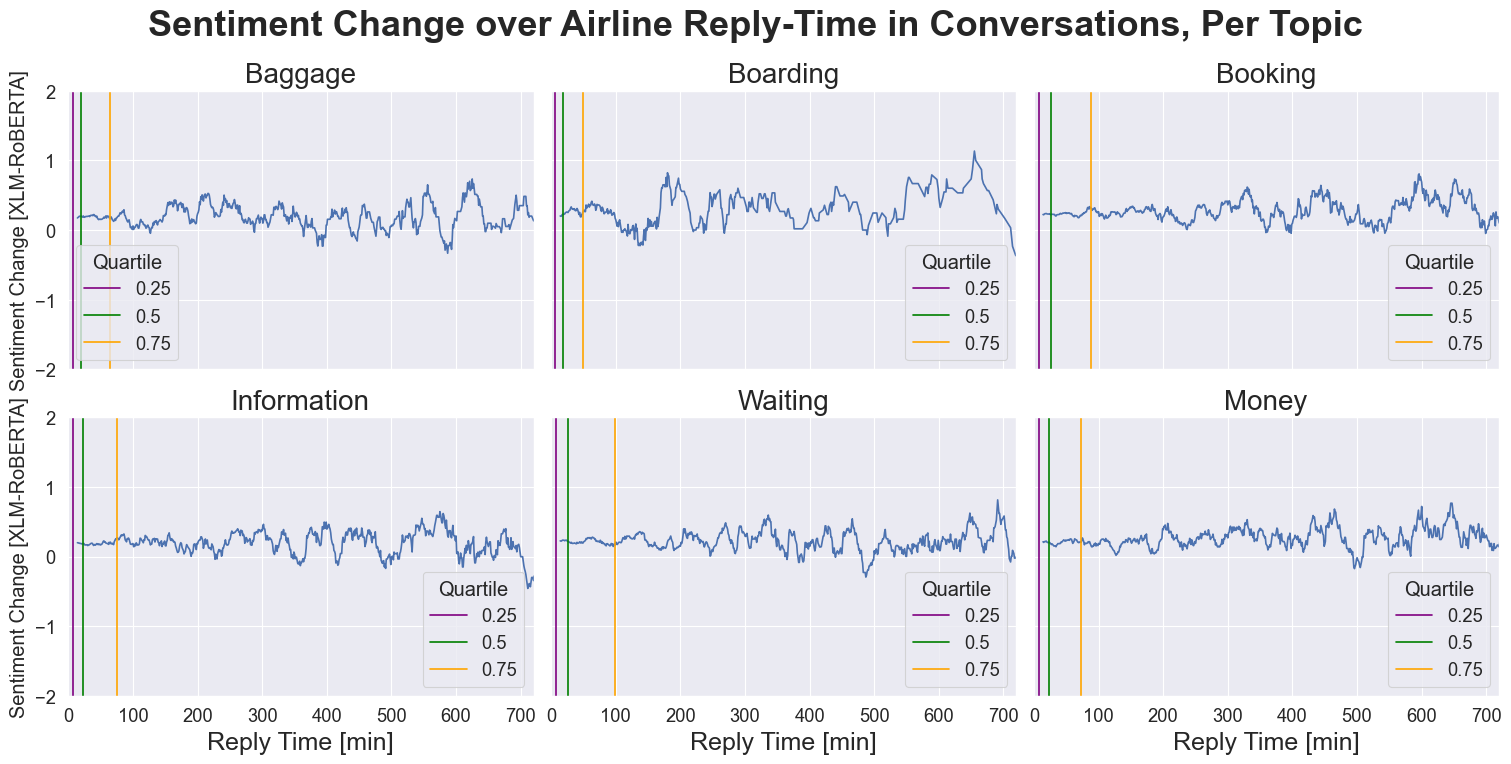

In [63]:
# Plot the results in line-plot with marked quantiles

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,7), sharey=True, sharex=True, layout="constrained")
plt.setp(ax, ylim=(-2,2))
plt.setp(ax, xlim=(-2,720))


# ROW 1
# Baggage
sns.lineplot(data=df_baggage_gro, x='reply_time', y='sentiment_change', ax=ax[0,0])
ax[0,0].axvline(x = baggage_qua5[0.25], c='purple', label='0.25')
ax[0,0].axvline(x = baggage_qua5[0.5], c='green', label='0.5')
ax[0,0].axvline(x = baggage_qua5[0.75], c='orange', label='0.75')
ax[0,0].legend(title = 'Quartile')
ax[0,0].set_title('Baggage', size=20)
ax[0,0].set_ylabel('Sentiment Change [XLM-RoBERTA]')

# Boarding
sns.lineplot(data=df_boarding_gro, x='reply_time', y='sentiment_change', ax=ax[0,1])
ax[0,1].axvline(x = boarding_qua5[0.25], c='purple', label='0.25')
ax[0,1].axvline(x = boarding_qua5[0.5], c='green', label='0.5')
ax[0,1].axvline(x = boarding_qua5[0.75], c='orange', label='0.75')
ax[0,1].legend(title = 'Quartile')
ax[0,1].set_title('Boarding', size=20)

# Booking
sns.lineplot(data=df_booking_gro, x='reply_time', y='sentiment_change', ax=ax[0,2])
ax[0,2].axvline(x = booking_qua5[0.25], c='purple', label='0.25')
ax[0,2].axvline(x = booking_qua5[0.5], c='green', label='0.5')
ax[0,2].axvline(x = booking_qua5[0.75], c='orange', label='0.75')
ax[0,2].legend(title = 'Quartile')
ax[0,2].set_title('Booking', size=20)

# ROW 2
# Information
sns.lineplot(data=df_information_gro, x='reply_time', y='sentiment_change', ax=ax[1,0])
ax[1,0].axvline(x = information_qua5[0.25], c='purple', label='0.25')
ax[1,0].axvline(x = information_qua5[0.5], c='green', label='0.5')
ax[1,0].axvline(x = information_qua5[0.75], c='orange', label='0.75')
ax[1,0].legend(title = 'Quartile')
ax[1,0].set_title('Information', size=20)
ax[1,0].set_xlabel('Reply Time [min]', size=18)
ax[1,0].set_ylabel('Sentiment Change [XLM-RoBERTA]')

# Waiting
sns.lineplot(data=df_waiting_gro, x='reply_time', y='sentiment_change', ax=ax[1,1])
ax[1,1].axvline(x = money_qua5[0.25], c='purple', label='0.25')
ax[1,1].axvline(x = money_qua5[0.5], c='green', label='0.5')
ax[1,1].axvline(x = money_qua5[0.75], c='orange', label='0.75')
ax[1,1].legend(title = 'Quartile')
ax[1,1].set_xlabel('Reply Time [min]', size=18)
ax[1,1].set_title('Waiting', size=20)

# Money
sns.lineplot(data=df_money_gro, x='reply_time', y='sentiment_change', ax=ax[1,2])
ax[1,2].axvline(x = waiting_qua5[0.25], c='purple', label='0.25')
ax[1,2].axvline(x = waiting_qua5[0.5], c='green', label='0.5')
ax[1,2].axvline(x = waiting_qua5[0.75], c='orange', label='0.75')
ax[1,2].legend(title = 'Quartile')
ax[1,2].set_title('Money', size=20)
ax[1,2].set_xlabel('Reply Time [min]', size=18)

fig.suptitle('Sentiment Change over Airline Reply-Time in Conversations, Per Topic', weight='bold', size=26, y=1.07);

# Sentiment per bin

In [64]:
file_path = Path("./output/sentiment_per_bin.csv")

# for each position, get 75%, 50%, 25% percentile
df = pd.read_csv(file_path)
# drop all columns not within the time frame
df = df[df["Tend"] <= end_date_unix]
df = df[df["Tstart"] >= start_date_unix]

# drop time columns
df = df.drop(columns=["Tstart", "Tend"])

# drop the bin_id column
df = df.drop(columns=["bin_id"])

# group the rows by bin_position
df = df.groupby(["bin_position"]).agg(lambda x: list(x))

df["75%"] = df["sentiment"].apply(lambda x: pd.Series(x).quantile(0.75))
df["50%"] = df["sentiment"].apply(lambda x: pd.Series(x).quantile(0.50))
df["25%"] = df["sentiment"].apply(lambda x: pd.Series(x).quantile(0.25))

# show the lengths per position
df["length"] = df["sentiment"].apply(lambda x: len(x))

# find the first row that has a length of 5
small_rows = df[df["length"] <= 5]

# get the index of the first row    
first_small_row = small_rows.index[0]
print(first_small_row)

# drop all rows after the first small row
df = df.drop(df.index[(first_small_row - 1):])
df = df.drop(columns=["length"])

17


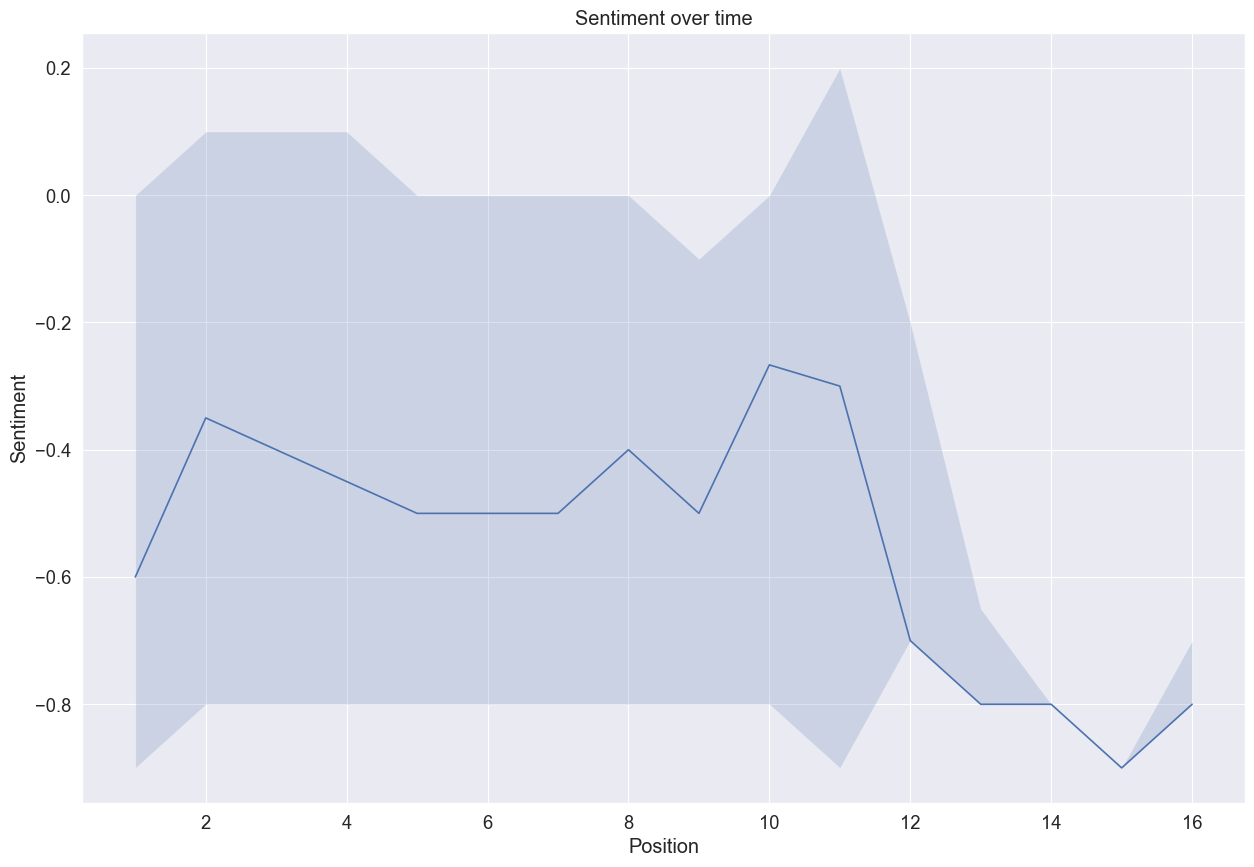

In [65]:
# Plot the line graph, coloring the area between 75% and 25%
ax = df.plot(y="50%", figsize=(15, 10), legend=False)
ax.fill_between(df.index, df["75%"], df["25%"], alpha=0.2)
ax.set_xlabel("Position")
ax.set_ylabel("Sentiment")
ax.set_title("Sentiment over time")
plt.show()

Multiple regression functions

In [66]:
# Connect to SQL database

connection=database.connect.getConnection()
cursor=connection.cursor(buffered=True)

In [67]:
#this cell contains all functions broken up to query all relevant variables into dataframes 
#all conversations queried involved airlines and have length of at least 3

def avg_resp_time():

    # creates a dataframe with conversation Id and avg reply time of the airlne throughout the conversation

    Query= (f"""
                SELECT part_of.cID, AVG(tweets.reply_time) 
                FROM tweets, part_of, conversations 
                WHERE tweets.id = part_of.tID AND part_of.cID = conversations.id AND conversations.Airline <> '0' 
                GROUP BY conversations.id
                """)
    execute=cursor.execute(Query)
    result=cursor.fetchall()
    df1 = pd.DataFrame(result)
    df1.columns = ['cID','reply_time']
    df1 = df1.set_index('cID')
    return df1


def init_sent():

    # Finds the initial sentiment and conversation length 
     try:
        Query = (f"""
                SELECT conversations.id, sentiment, conversations.Length, conversations.Tstart, conversations.Tend
                FROM conversations , part_of ,tweets
                WHERE conversations.ID = part_of.cID AND tweets.id=part_of.tID AND Position = 1 and conversations.Airline <>'0';

                 """)
        execute = cursor.execute(Query)
        result = cursor.fetchall()
        df2 = pd.DataFrame(result)
        df2.columns = ['cID','init_sentiment','Length','Tstart','Tend']
        df2 = df2.set_index('cID')
        return df2

     except:
        print("Error")
        return 0.00


def sent_change():

    # Finds the avg sentiment change per conversation
    try:
        Query = (f"""
                 SELECT bs1.cID, CASE
	            WHEN (bs1.sentiment_sum/bs1.tweet_count) > (bs2.sentiment_sum / bs2.tweet_count) THEN -1*ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
                 ELSE ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
                END AS average_sent_diff
                    FROM `binned_sentiment` bs1, `binned_sentiment` bs2, (SELECT cID, MAX(bin_position) AS max_pos FROM `binned_sentiment` GROUP BY cID) AS max_bins WHERE bs1.cID = bs2.cID AND bs1.cID = max_bins.cID AND bs1.bin_position= 1 AND bs2.bin_position=max_pos
                
                    """)
        execute = cursor.execute(Query)
        result = cursor.fetchall()
        
        df3 = pd.DataFrame(result)
        df3.columns = ['cID','avg_sent_change']
        df3 = df3.set_index('cID')
        return df3

    except:
        print("Error")
        return 0.00

def get_conversation_categories():
    excluided = ['dm', 'customers', 'information']
    relevant_categories = [key for key in categories.keys() if key not in excluided]
    # for each conversation, get weather it incluides a category.
    # returns a dataframe with the conversation id and the categorys
    categories_query = ""

    for category in relevant_categories:
        categories_query += f"(CASE WHEN tweets.{category} != 0 THEN 1 ELSE 0 END) AS {category}, "

    query = (f"""
                SELECT part_of.cID, {categories_query[:-2]}
                FROM tweets, part_of
                WHERE tweets.id = part_of.tID 
                GROUP BY part_of.cID
                """)
    execute = cursor.execute(query)
    result = cursor.fetchall()
    df4 = pd.DataFrame(result)
    df4.columns = ['cID'] + relevant_categories
    # remove the index column
    df4 = df4.set_index('cID')
    return df4

In [68]:
#creates table
df_avg_resp_time=avg_resp_time()
df_sent_change=sent_change()
df_init_sent=init_sent()
df_convo_cat=get_conversation_categories()

ProgrammingError: 1055 (42000): Expression #2 of SELECT list is not in GROUP BY clause and contains nonaggregated column 'dbl3.tweets.booking' which is not functionally dependent on columns in GROUP BY clause; this is incompatible with sql_mode=only_full_group_by

In [ ]:
# Join the data frames on the shared index 'cID'
joined_df = pd.merge(df_avg_resp_time, df_sent_change, on='cID')
joined_df = pd.merge(joined_df, df_init_sent, on='cID')
joined_df = pd.merge(joined_df, df_convo_cat, on='cID')
joined_df=joined_df.apply(pd.to_numeric, errors='coerce')
#pick out datetime
joined_df = joined_df[(joined_df['Tstart'] >= start_date_unix) & (joined_df['Tend'] <= end_date_unix)]
#remove date time
joined_df = joined_df.drop(['Tstart', 'Tend'], axis=1)

# Print the joined data frame to check
print(joined_df.head())

       reply_time  avg_sent_change  init_sentiment  Length  booking  \
cID                                                                   
35   3.412596e+06              0.1       -0.108448       7        0   
46   3.947679e+08              0.0        0.011900       3        0   
67   1.759073e+07              0.0        0.064438       4        0   
71   4.859813e+07              0.1       -0.023518       4        0   
72   3.887300e+07              0.0       -0.023518       5        0   

     canceling  money  baggage  staff  waiting  boarding  stuck  
cID                                                              
35           0      0        0      0        0         0      0  
46           0      1        0      0        0         0      0  
67           0      0        0      0        0         0      0  
71           0      0        0      0        0         0      0  
72           0      0        0      0        0         0      0  


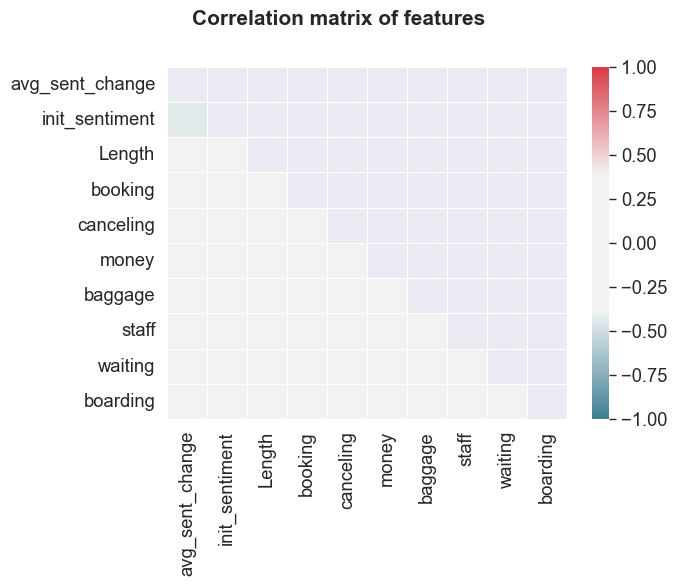

In [ ]:
def corr_matrix():
    # function takes in dataframe and creates a correlation matrix
    df =joined_df

    df = df.iloc[:, 1:-1]

    corr = df.corr(method='spearman')

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(7, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    fig.suptitle('Correlation matrix of features', fontsize=15,fontweight='bold')


    fig.tight_layout()

corr_matrix()

In [ ]:
def multiple_regress():
    #function takes in dataframe and returns all coeffients and r^2 of the fit model.
    df = joined_df

    features = ['reply_time', 'init_sentiment', 'Length', 'booking','canceling','money','baggage','staff','waiting','boarding','stuck']
    target = 'avg_sent_change'

    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)

    #model.coef_

    print('Features                :  %s' % features)
    print('Regression Coefficients : ', [round(item, 7) for item in model.coef_])
    print('R-squared               :  %.2f' % model.score(X, y))
    print('Y-intercept             :  %.2f' % model.intercept_)
    print('')
multiple_regress()


Features                :  ['reply_time', 'init_sentiment', 'Length', 'booking', 'canceling', 'money', 'baggage', 'staff', 'waiting', 'boarding', 'stuck']
Regression Coefficients :  [0.0, -0.5100913, -0.0076307, 0.0324536, -0.1098655, -0.0747869, -0.0596363, -0.0510902, -0.0885004, 0.0173946, -0.0799084]
R-squared               :  0.22
Y-intercept             :  0.06

